<h1>Twitter Sentiment Analysis for Social Capital</h1>

In [2]:
# load dependencies
import tweepy
import dataset
import json
from sqlalchemy.exc import ProgrammingError
import textblob
import time
import numpy as np
import pandas as pd
import sqlite3
import os

# create sqlite db if none exists, else append
db = dataset.connect("sqlite:///tweets_lse.db")

# set api constants
TWITTER_APP_KEY = 'pfekrUmzHx0WY4gNjQaIsjmjH'
TWITTER_APP_SECRET = 'OkZxpDJIMEtttGnUWigqhGvK4WqNnZLDLg79codmz56JZBhO9Q'
TWITTER_KEY = '1439343834-7xzhsIyOJYETIwiMaaZXj3qm1gQq0bge1QwgwRy'
TWITTER_SECRET = 'wjyIx0p1l7P2OB9jarfmRR500yzn7MOogJiSA9HEAh4qz'

# set OAuth authentication
auth = tweepy.OAuthHandler(TWITTER_APP_KEY, TWITTER_APP_SECRET)
auth.set_access_token(TWITTER_KEY, TWITTER_SECRET)

# create API object to pull twitter data, passing in authentication
api = tweepy.API(auth, 
                 retry_count = 5, # default number of retries to attempt when error occurs
                 retry_delay = 5, # number of seconds to wait between retries
                 wait_on_rate_limit = True, # Whether or not to automatically wait for rate limits to replenish
                 wait_on_rate_limit_notify = True) # Whether or not to print a notification when Tweepy is waiting for rate limits to replenish

# create class that inherits from streamlistener object
class StreamListener(tweepy.StreamListener):
    
    # override on_status method to define our own functionality     
    def on_status(self, status):
        
        # print all tweets that are not retweets         
        if hasattr(status, 'retweeted_status'):
            return
        
        description = status.user.description
        loc = status.user.location
        retweets = status.retweet_count
        favourites = status.favorite_count
        followers_count = status.user.followers_count
        text = status.text
        place = status.place.full_name
        coords = status.coordinates
        name = status.user.screen_name
        created_at = status.created_at
        
        blob = textblob.TextBlob(text)
        sentiment = blob.sentiment
        
        # only return geotagged tweets         
        if coords is None:
            return
            
        # encode to json         
        if coords is not None:
            coords = json.dumps(coords)
            coords = json.loads(coords)            
            lon = coords['coordinates'][0]
            lat = coords['coordinates'][1]
        
        # create reference point for db         
        table = db["tweets"]
        
        # try to insert to sqlite db         
        try:
            table.insert(dict(
                created_at = created_at,
                retweets = retweets,
                favourites = favourites,
                user_description=description,
                followers_count = followers_count,
                user_location=loc,
                place=place,
                lat=lat,
                lon=lon,
                text=text,
                user_name=name,
                polarity = sentiment.polarity,
                subjectivity = sentiment.subjectivity
            ))
        # catch any error          
        except ProgrammingError as err:
            logging.INFO(err)

    def on_error(self, status_code):
        # if being rate limited, return false         
        if status_code == 420:
            return False
        
def timeout_test(func):
    
    def wrapper(*args):
        t = time.clock()
        res = func(*args)
        print(func.__name__, time.clock() - t)
        return res
    
    return wrapper

@timeout_test # scrap = timer(call_scraper)
def call_scraper(geo):
    # instantiate streamlistener object from class
    stream_listener = StreamListener()

    # connect to twitter API to create stream object
    stream = tweepy.Stream(auth=api.auth, listener=stream_listener)

    # apply custom filtering
    stream.filter(locations=geo, languages=['en'])

In [55]:
import logging

# set logger
logger = logging.getLogger()
fhandler = logging.FileHandler(filename='twitter_log.log', mode='a')
formatter = logging.Formatter('%(asctime)s %(message)s')
fhandler.setFormatter(formatter)
logger.addHandler(fhandler)
logger.setLevel(logging.DEBUG)

# set geo
bbox_geo = [-10.8544921875, 49.82380908513249, 2.021484375, 59.478568831926395]

# call function with decorator method
call_scraper(bbox_geo)

KeyboardInterrupt: 

In [8]:
# connect to sqlite database
db = dataset.connect("sqlite:///tweets_lse.db")

# return all from database instance
result = db["tweets"].all()

# dump sqlite to csv
dataset.freeze(result, format='csv', filename='twitter_lse.csv')

In [3]:
cnx = sqlite3.connect(os.path.join(os.path.dirname('__file__'), 'tweets_lse.db'))

#  query sqlite table
lse_df = pd.read_sql_query('SELECT * FROM tweets', cnx)

lse_df

,id,created_at,retweets,favourites,user_description,followers_count,user_location,place,lat,lon,text,user_name,polarity,subjectivity
0,1,2017-07-07 11:50:04.000000,0,0,"Celebrity MakeupArtist for TV/Film, Music Vide...",2023,"Slough, Heathrow London.","Slough, South East",51.510000,-0.593100,FEMALE MODELS NEEDED for NEXT WEEK - 11am to 3...,RizKhanMua,0.000000,0.083333
1,2,2017-07-07 11:50:06.000000,0,0,Real Time Solar updates from Oxford. See the s...,48,Oxford,"Oxford, England",51.724849,-1.232882,2879 watts.\n73% Battery = 1.46kWh https://t.c...,OxfordSolarLive,0.000000,0.000000
2,3,2017-07-07 11:50:07.000000,0,0,Weather conditions updated every 10 minutes fr...,828,"Woking, England","Woking, South East",51.332222,-0.557778,Tmp 32.9°C Wind 10mph Press 1013.2mb Cloud 900...,WeatherWoking,0.208333,0.750000
3,4,2017-07-07 11:50:08.000000,0,0,(As Seen On The Only Way Is Essex) •Sunbeds •H...,8810,"217 Highstreet Epping, Essex","Hertford, East",51.796091,-0.076074,✨✨👌🏽FRESH HAIR FRIDAY!!👌🏽✨✨\n\n•Blow By Junior...,SoGlamEssex,0.000000,0.000000
4,5,2017-07-07 11:50:09.000000,0,0,"International stylist, colour evangelist. Spea...",573,"London, England","Ealing, London",51.511100,-0.307228,"Do your thing your way, it's the only way.\n\n...",Jobaldwintrott,0.216667,0.716667
5,6,2017-07-07 11:50:09.000000,0,0,| skins & ivories |,1544,London,"Islington, London",51.534370,-0.106129,last night's fun. @ O2 Academy Islington https...,jimmolyneux,0.150000,0.133333
6,7,2017-07-07 11:50:12.000000,0,0,"Hi I am Mitchell! I am 23 years old, love Poké...",7,"Perth, Western Australia","Merton, London",51.434360,-0.214262,Finally at #Wimbledon for the first time!! Goi...,mitchoishere,0.347656,0.408333
7,8,2017-07-07 11:50:15.000000,0,0,방탄소년단 —— teamwork makes the dream work. #정국 ♡,221,None,"Bicester, England",51.892040,-1.155603,"(at @BicesterVillage in Bicester, Oxfordshire)...",palmypattareeya,0.000000,0.000000
8,9,2017-07-07 11:50:17.000000,0,0,"Farm vet, Yorkshire.",58,"York, England","Murton, England",53.963720,-1.009620,Just in time for the weekend!! #craftginclub @...,ashmarshallvet,0.000000,0.000000
9,10,2017-07-07 11:50:22.000000,0,0,"Cancer survivor and blogger, CSR and animal lo...",586,London,"East, England",51.727950,-0.469812,Amazing #wedding last night! @ Shendish Manor ...,alexsam_89,0.300000,0.483333


In [5]:
import json
import random
import sys

from expects import expect, equal
from expects.matchers.built_in import be_above
from expects.matchers.built_in.have_keys import have_key

import pytest
from requests import *
from pprint import pprint
import uuid
from datetime import datetime

sys.path.insert(0, './python')

import conftest
import factories

content = lse_df['text']

# remove punctuation, stop words and lemmatize words
content = [clean(tweet) for tweet in list(content)] # consider common internet notations

In [6]:
content

['female model needed next week 11am 3pm tfp hair n makeup mon 10th july tues… httpstco1f66mq4weh',
 '2879 watt 73 battery 146kwh httpstcooxe9wi7fjw',
 'tmp 329°c wind 10mph press 10132mb cloud 9004 ft rain 00mm humidity 26 fine possible shower ukweather',
 '✨✨👌🏽fresh hair friday👌🏽✨✨ •blow junior stylist brandon ☎️01992570177 hair blowdry pincurls rollers… httpstcozvcwbfkgwj',
 'thing way it way sometimes point becoming entrepreneur… httpstcoiqbciulbve',
 'last night fun o2 academy islington httpstcoduovqt6rw0',
 'finally wimbledon first time going see best double girl later today… httpstcoiku7vxgf3e',
 'at bicestervillage bicester oxfordshire httpstcoqlnzw6potm',
 'time weekend craftginclub york auction centre httpstcofnyhdzgxvu',
 'amazing wedding last night shendish manor hotel amp golf course httpstco245cct7b91',
 'drinking american pale ale shipyardbrewingmarstonsbrewery back beyond wetherspoon — httpstcoxz6vpvbrdk',
 'enjoying greatbritishsummer ☺️🏖 summer uk фотографвлондоне лет

In [18]:
import datetime

In [19]:
# define constants
BASE_URL = 'https://api.receptiviti.com/'
APIKEY = '595f54e5572c16057117ff51'
APISECRET = 'DDG2alP30PiobcqCuyspe57U9hK780FuoGUG2mC4NiQ'

def get_content_data(content, **kwargs):
    attribs = {
        "language_content": content,
        "gender": 0, # cant assign gender
        "content_source": random.randint(1, 2),
        "content_handle": uuid.uuid4().hex,
        "content_date": datetime.datetime.now().isoformat(),
        "recipient_id": None,
        "content_tags": ['twitter', 'sentiment'],
        "content_source": 8, # twitter content
        'language': 'english'
    }
    attribs.update(kwargs)
    return attribs

def get_person_data(content=None):
    person_data = {'name': "John {0} Doe".format(uuid.uuid4().hex), 'person_handle': uuid.uuid4().hex, 'gender': 1}
    if content:
        person_data["content"] = content
    return person_data

@pytest.mark.person_api
def get_sentiment(baseurl, apikey, apisecret, content):
    content_data = get_content_data(content)
    person_data = get_person_data(content_data)

    
    person_api_url = conftest.person_api_url(baseurl)
    auth_headers = conftest.auth_headers(apikey, apisecret)
    
    response = post(person_api_url, json=person_data, headers=auth_headers)
    response_json = json.loads(response.content)
    
    expect(response.status_code).to(equal(200))
    expect(response_json["name"]).to(equal(person_data["name"]))
    expect(response_json["contents"][0]).to(have_key("receptiviti_scores"))
    expect(response_json["contents"][0]).to(have_key("liwc_scores"))
    
    return response_json

sents = [get_sentiment(BASE_URL, APIKEY, APISECRET, tweet) for tweet in content]

In [20]:
sents

[{'_id': '5964bbd9e8947f058944df2d',
  '_links': {'contents': {'href': '/v2/api/person/5964bbd9e8947f058944df2d/contents',
    'method': 'GET'},
   'self': {'href': '/v2/api/person/5964bbd9e8947f058944df2d',
    'method': 'GET'}},
  'content_count': 1,
  'contents': [{'_id': '5964bbd9e8947f058944df2e',
    'communication_recommendation': 'Try to avoid telling them what to do. Avoid placing tight constraints on them, such as short timelines. Try to focus on the here-and-now instead of the future.',
    'content_date': '2017-07-11T12:51:47.885000+00:00',
    'content_handle': '88455093cea54f25ac77ad5cee92fcb9',
    'content_source': 8,
    'content_tags': ['twitter', 'sentiment'],
    'created': '2017-07-11T11:51:53.344000+00:00',
    'custom_fields': {},
    'emotional_analysis': {'emotional_tone': {'rating': 'Negative',
      'score': 25.774195},
     'facets': {'anger': 0.0, 'fear': 0.0, 'sad': 0.0}},
    'language': 'english',
    'liwc_scores': {'analytic': 92.83501,
     'authentic

In [54]:
print(content[0])
print()
pprint(sents[0]['contents'])

female model needed next week 11am 3pm tfp hair n makeup mon 10th july tues… httpstco1f66mq4weh

[{'_id': '5961feb0e8947f058944db42',
  'communication_recommendation': 'Try to avoid telling them what to do. Avoid '
                                  'placing tight constraints on them, such as '
                                  'short timelines. Try to focus on the '
                                  'here-and-now instead of the future.',
  'content_date': '2017-07-09T11:00:03.179000+00:00',
  'content_handle': 'e6ed4645e7514854aaf5f7c00f513740',
  'content_source': 1,
  'content_tags': ['tag1', 'tag2', 'tag3'],
  'created': '2017-07-09T10:00:16.332000+00:00',
  'custom_fields': {},
  'emotional_analysis': {'emotional_tone': {'rating': 'Negative',
                                            'score': 25.774195},
                         'facets': {'anger': 0.0, 'fear': 0.0, 'sad': 0.0}},
  'language': 'english',
  'liwc_scores': {'analytic': 92.83501,
                  'authentic': 74.76

In [65]:
def _print_interesting_content_information(response_json):
    print("Authenticity Score: {}".format(response_json["liwc_scores"]["authentic"]))
    print("Thinking Style: {}".format(response_json["receptiviti_scores"]["percentiles"]["thinking_style"]))
    print("Personality Snapshot: {}".format(response_json["personality_snapshot"]))
    print("Communication Recommendation: {}".format(response_json["communication_recommendation"]))

_print_interesting_content_information(sents[0]['contents'][0])

Authenticity Score: 74.76344
Thinking Style: 92.02599894498732
Personality Snapshot: [{'description': "Values making their own decisions, enjoys control, and strives for autonomy. Doesn't like to be told what to do or rely on others for help or support.", 'summary': 'Independent'}, {'description': 'Relaxed, takes problems as they come, very patient and slow to anger. Does not experience stress when confronted with deadlines or problems. Typically makes others feel relaxed and comfortable. Does not get particularly bothered by a lack of ability in others.', 'summary': 'Easy-going'}, {'description': 'Focused on the needs of the group. Places importance on harmony and close bonds with others. Prefers that everyone has a voice when making decisions. Likes peaceful interactions, dislikes conflict and people who assert themselves over others.', 'summary': 'Harmony-seeking'}]
Communication Recommendation: Try to avoid telling them what to do. Avoid placing tight constraints on them, such as s

<h1>Latent Dirichlet Analysis (LDA)</h1>

In [9]:
doc_complete = list(lse_df['text'])

from nltk.corpus import stopwords 
from nltk.stem.wordnet import WordNetLemmatizer
import string
import gensim
from gensim import corpora

stop = set(stopwords.words('english'))
exclude = set(string.punctuation)

# get base form lemmatiser for disambiguating words
lemma = WordNetLemmatizer()

def clean(doc):
    
    stop_free = ' '.join([i for i in doc.lower().split() if i not in stop])
    
    punc_free = ''.join(ch for ch in stop_free if ch not in exclude)
    
    normalized = ' '.join(lemma.lemmatize(word) for word in punc_free.split())
    
    return normalized

doc_clean = [clean(doc) for doc in doc_complete]
t = [doc.split() for doc in doc_clean]

# create term dict of corpus
dictionary = corpora.Dictionary(t)

* alpha - document-topic density (high value = more topics)
* beta - topic-word density (high beta = topics composed of a large number of words)

In [11]:
corpus = [dictionary.doc2bow(doc) for doc in t]

# build document term matrix
doc_term_matrix = [dictionary.doc2bow(doc) for doc in t]

lda = gensim.models.ldamodel.LdaModel

ldamodel = lda(doc_term_matrix, num_topics=5, id2word = dictionary, passes=50, alpha=0.01)

print(ldamodel.print_topics(num_topics=5, num_words=3))

[(0, '0.022*"love" + 0.015*"job" + 0.015*"chocolate"'), (1, '0.019*"london" + 0.013*"last" + 0.013*"canal"'), (2, '0.021*"146kwh" + 0.021*"73" + 0.021*"battery"'), (3, '0.014*"hair" + 0.014*"headband" + 0.014*"livia"'), (4, '0.014*"first" + 0.014*"way" + 0.014*"time"')]


In [13]:
import pyLDAvis.gensim

lda_vis = pyLDAvis.gensim.prepare(ldamodel, corpus=corpus, dictionary=dictionary)

pyLDAvis.display(lda_vis)

c:\xampp\htdocs\conda\lib\site-packages\pyLDAvis\_prepare.py:387: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
  topic_term_dists = topic_term_dists.ix[topic_order]


<h1>word2vec</h1>

In [25]:
# load test set
headers = ['x','y','text','created_at']
tweets_test = pd.read_csv(os.path.join(os.path.dirname('__file__'), '..', '..', 'tweets_db', 'training_set_tweets.txt'), 
                          sep='\t',
                          error_bad_lines=False,
                          names=headers)

tweets_test = tweets_test.dropna()

c:\xampp\htdocs\conda\lib\site-packages\IPython\core\interactiveshell.py:2683: DtypeWarning: Columns (0,1) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [261]:
from nltk.corpus import stopwords 
from nltk.stem.wordnet import WordNetLemmatizer
import string
from itertools import chain
import re
from sklearn.manifold import TSNE
import tensorflow as tf

tweets_test_sample = tweets_test[0:10000]
tweets_test_sample = tweets_test_sample.dropna()

stop = set(stopwords.words('english'))
stop.add('rt')
exclude = set(string.punctuation)

# get base form lemmatiser for disambiguating words
lemma = WordNetLemmatizer()

def clean(doc):
    # remove url
    doc = re.sub(r'http\S+', '', doc)
    
    # remove stop words 
    stop_free = ' '.join([i for i in doc.lower().split() if i not in stop and type(i) is str])
    
    # remove punctuation
    punc_free = ''.join(ch for ch in stop_free if ch not in exclude)
    
    # lemmatize words (remove infectional endings and return base form of words)
    normalized = ' '.join(lemma.lemmatize(word) for word in punc_free.split())
    
    return normalized

cleaned_tweets = [clean(tweet) for tweet in tweets_test_sample['text']]

In [262]:
from itertools import chain
import collections

bag_of_words = list(chain.from_iterable([i.split() for i in cleaned_tweets]))
print('Data size %d words' % len(bag_of_words))

def build_datasets(words):
    # create count list, set count for UNK token to -1 (undefined)
    count = [['UNK', -1]]
    # add counts of the 49,999 most common tokens in 'words'
    count.extend(collections.Counter(words).most_common(vocabulary_size - 1))
    # create the dict data structure
    dictionary = {}
    # give unique id to each token in the dictionary
    for word, _ in count:
        dictionary[word] = len(dictionary)
    # create list for the data
    data= []
    # keep track of the number of UNK tokens
    unk_count = 0
    
    for word in words:
        # if in dictionary, get its index
        if word in dictionary:
            index = dictionary[word]
        # else set index as zero and increment UNK count
        else:
            index = 0
            unk_count += 1
        data.append(index)
        
        # set count of UNK in the count data structure
        count[0][1] = unk_count
        # invert the dictionary, becoming (index, word) kv pairs
        reverse_dictionary = dict(zip(dictionary.values(), dictionary.keys()))
    
    return data, count, dictionary, reverse_dictionary
    
    
data, count, dictionary, reverse_dictionary = build_datasets(bag_of_words)
vocabulary_size = len(dictionary)
print(len(dictionary))
del bag_of_words # free up memory
print("Most common words", count[:10])
print("Sample data", data[:10], [reverse_dictionary[i] for i in data[:10]])

Data size 82082 words
17744
Most common words [['UNK', 0], ('new', 561), ('it', 552), ('im', 494), ('get', 460), ('u', 418), ('good', 348), ('like', 325), ('day', 307), ('one', 280)]
Sample data [3617, 4830, 18, 1628, 324, 3617, 216, 836, 7328, 506] ['thediscovietnam', 'coo', 'thanks', 'dropped', 'line', 'thediscovietnam', 'shit', 'aint', 'lettin', 'dm']


In [263]:
# generate mini batches (number of training examples in one forward/backward pass)
import random

data_index = 0

def generate_batch(batch_size, num_skips, skip_window):
    global data_index
    # assert parameters are self-consistent
    assert batch_size % num_skips == 0
    assert num_skips <= 2 * skip_window
    # create empty batch ndarray using 'batch size'
    batch = np.ndarray(shape=(batch_size), dtype=np.int32)
    # create empty labels ndarray using 'batch_size'
    labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
    # [ skip_window target skip_window ]
    span = 2 * skip_window + 1
    # create a buffer object for prepping batch data
    buffer = collections.deque(maxlen=span)
    # for each element in our span, append datum at data_index and increment data_index
    for _ in range(span):
        buffer.append(data[data_index])
        data_index = (data_index + 1) % len(data)
    for i in range(batch_size // num_skips):
        # target label at center of buffe
        target = skip_window
        targets_to_avoid = [skip_window]
        for j in range(num_skips):
            # look over targets to avoid
            while target in targets_to_avoid:
                target = random.randint(0,span-1)
            targets_to_avoid.append(target)
            #set skip window in minibatch data
            batch[i * num_skips + j] = buffer[skip_window]
            # set the target in the minibatch labels
            labels[i * num_skips + j, 0] = buffer[target]
        # add the data at the current 'data_index' to the buffer
        buffer.append(data[data_index])
        # increment 'data_index'
        data_index = (data_index + 1) % len(data)
    # return the minibatch data and corresponding labels
    return batch, labels

batch, labels = generate_batch(batch_size=8, num_skips=2, skip_window=1)

for i in range(5):
    print(batch[i], reverse_dictionary[batch[i]], '->', labels[i, 0], reverse_dictionary[labels[i,0]])

4830 coo -> 18 thanks
4830 coo -> 3617 thediscovietnam
18 thanks -> 1628 dropped
18 thanks -> 4830 coo
1628 dropped -> 18 thanks


In [250]:
vocabulary_size = 50000

<h1>Build computation graph</h1>

In [264]:
# TUTORIAL:
# https://iksinc.wordpress.com/tag/continuous-bag-of-words-cbow/
# https://github.com/tensorflow/tensorflow/blob/master/tensorflow/examples/udacity/5_word2vec.ipynb
# https://stackoverflow.com/questions/40581010/how-to-run-tsne-on-word2vec-created-from-gensim visualise with gensim using tnse
# http://www-edlab.cs.umass.edu/~djsaunde/word2vec.html tensorflow skipgram tutorial

# set hyperparameters
batch_size = 128
embedding_size = 128 # vector dimensionality
skip_window = 1 # how many words to consider left and right
num_skips = 2 # how many times to reuse input to generate label

valid_size = 16 # size of random set of words to evaluate similarity on
valid_window = 100 # only pick development samples from the first 'valid_window' words
valid_examples = np.random.choice(valid_window, valid_size, replace=False)
num_sampled = 64 # number of negative examples to sample

graph = tf.Graph()

with graph.as_default():
    # input data
    train_inputs = tf.placeholder(tf.int32, shape = [batch_size])
    train_labels = tf.placeholder(tf.int32, shape = [batch_size, 1])
    valid_dataset = tf.constant(valid_examples, dtype=tf.int32)
    
    # operations and variables
    embeddings = tf.Variable(tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
    embed = tf.nn.embedding_lookup(embeddings, train_inputs)
    
    # construct variables for NCE loss
    nce_weights = tf.Variable(tf.truncated_normal([vocabulary_size, embedding_size], stddev=1.0 / math.sqrt(embedding_size)))
    nce_biases = tf.Variable(tf.zeros([vocabulary_size]))
    
    # compute the average NCE loss for thebatch
    loss = tf.reduce_mean(tf.nn.nce_loss(weights=nce_weights,  biases=nce_biases, labels = train_labels,  inputs=embed,num_sampled=num_sampled, num_classes=vocabulary_size))
    
    # construct the SGD optimizer using a learning rate of 1.0
    optimizer = tf.train.GradientDescentOptimizer(1.0).minimize(loss)
    
    # compute cosine similarity between minibatch examples and all embeddings 
    norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
    normalized_embeddings = embeddings / norm
    valid_embeddings = tf.nn.embedding_lookup(normalized_embeddings, valid_dataset)
    
    similarity = tf.matmul(valid_embeddings, normalized_embeddings, transpose_b=True)
    
    # add variable initializer
    init = tf.global_variables_initializer()

In [265]:
# train the model

num_steps = 25000

with tf.Session(graph=graph) as session:
    # initialize all variables before using
    init.run()
    print('Initialized')
    
    # loop over training steps and track loss
    average_loss = 0
    for step in range(num_steps):
        # generate minibatch of training data
        batch_inputs, batch_labels = generate_batch(batch_size, num_skips, skip_window)
        feed_dict = {train_inputs: batch_inputs, train_labels: batch_labels}
        
        # we perform a single udate step evaluating the optimizer 
        _, loss_val = session.run([optimizer, loss], feed_dict=feed_dict)
        average_loss += loss_val
        
        # print average loss every 2000 steps
        if step % 2000 == 0:
            if step > 0:
                average_loss /= 2000
            # average loss is an estimate of the loss over last 2000 batches
            print("Average loss at step ", step, ": ", average_loss)
            average_loss = 0
            
        # compute cosine similarity
        if step % 10000 == 0:
            sim = similarity.eval()
            for i in range(valid_size):
                valid_word = reverse_dictionary[valid_examples[i]]
                
                # number of nearest neighbours
                top_k = 8
                # compute nearest neighbours
                nearest = (-sim[i, :]).argsort()[1:top_k + 1]
                log_str = "nearest to %s:" % valid_word
                for k in range(top_k):
                    close_word = reverse_dictionary[nearest[k]]
                    log_str = "%s %s," % (log_str, close_word)
                print(log_str)
    final_embeddings = normalized_embeddings.eval()

Initialized
Average loss at step  0 :  267.51272583
nearest to good: niece, hlps, plastic, bloody, lovellpr, doing, starexisting, disappear,
nearest to first: wwd, refurb, feature, manipulative, inspired, oooh, fireshot, 16000,
nearest to getting: whitethey, dismayyoull, paas, based, dated, reinforce, lptv, co,
nearest to video: luv, chill, basis, police, franssen, nevermind, kandinsky, 1941,
nearest to thanks: jetblue, duck, kt, d300, litt, scotmckay, project, il,
nearest to lot: audio, w, nasa, smile, discourse, fashioned, 310, raffi,
nearest to guy: recmmnd, happenin, everything, hawaiian, gipsy, spike, noodle, spirito,
nearest to make: wwwtheonlinebeatcom, participating, recessiongood, signature, bohrring, ameliag, blogged, animation,
nearest to today: purrrrrrr, picking, partaking, thefinances, annadollie, brilliants, cash, control,
nearest to free: yellow, smoke, tally, him, tozer, accepting, father, katelynofficial,
nearest to you: cohost, inpond, 5919775761, benefit, pinkslipmi

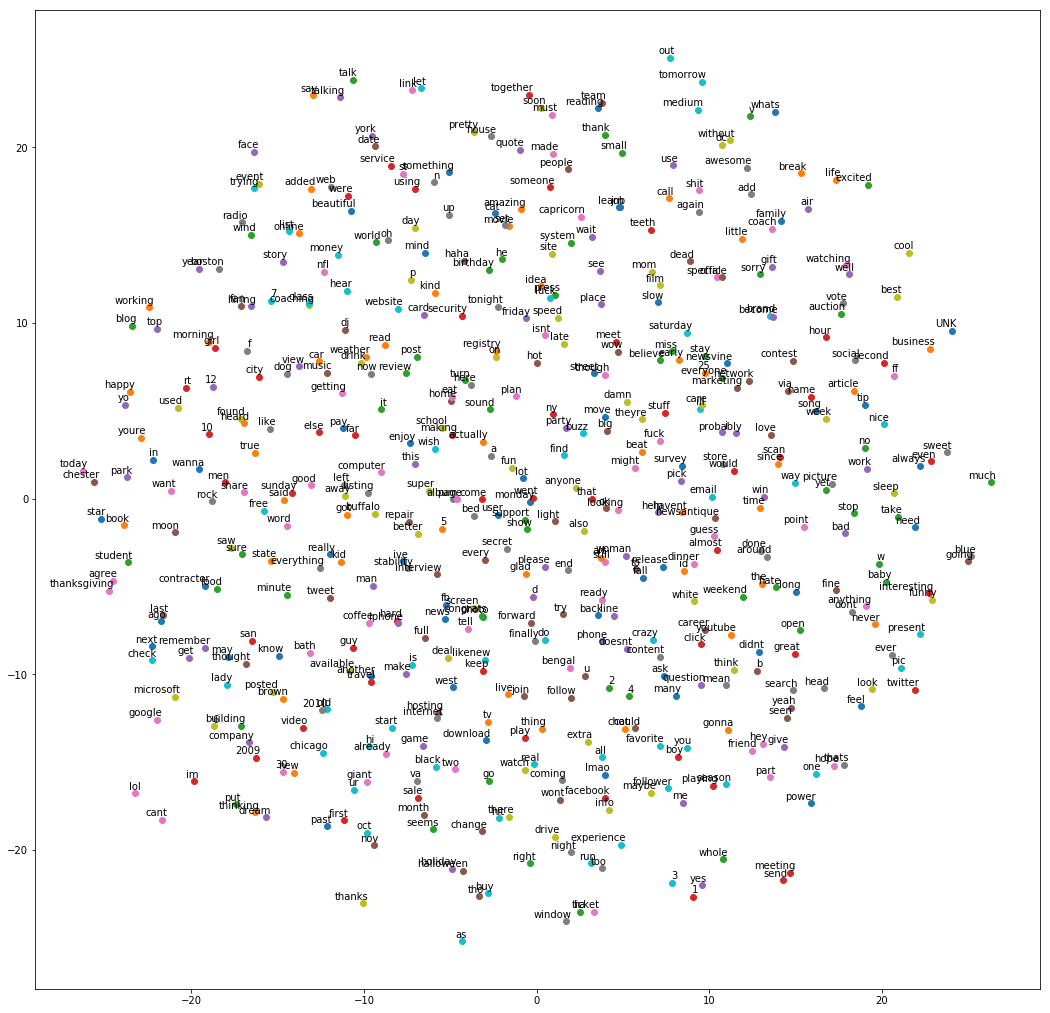

In [270]:
def plot_with_labels(low_dim_embs, labels, filename='tsne.png'):
    assert low_dim_embs.shape[0] >= len(labels), "More labels than embeddings"
    
    plt.figure(figsize=(18,18))
    
    for i, label in enumerate(labels):
        x,y = low_dim_embs[i,:]
        plt.scatter(x,y)
        plt.annotate(label, xy=(x,y), xytext=(5,2), textcoords='offset points', ha='right', va='bottom')
        
    plt.savefig(filename)
    
try:
    # import t-SNE and matplotlib.pyplot
    from sklearn.manifold import TSNE
    import matplotlib.pyplot as plt
    
    %matplotlib inline
    
    tsne =TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
    plot_only = 500
    low_dim_embs = tsne.fit_transform(final_embeddings[:plot_only, :])
    labels = [reverse_dictionary[i] for i in range(plot_only)]
    plot_with_labels(low_dim_embs, labels)
    
except ImportError:
    print("Please install packages")